Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/Users/edeno/miniconda3/envs/non_local_detector/lib/python3.11/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


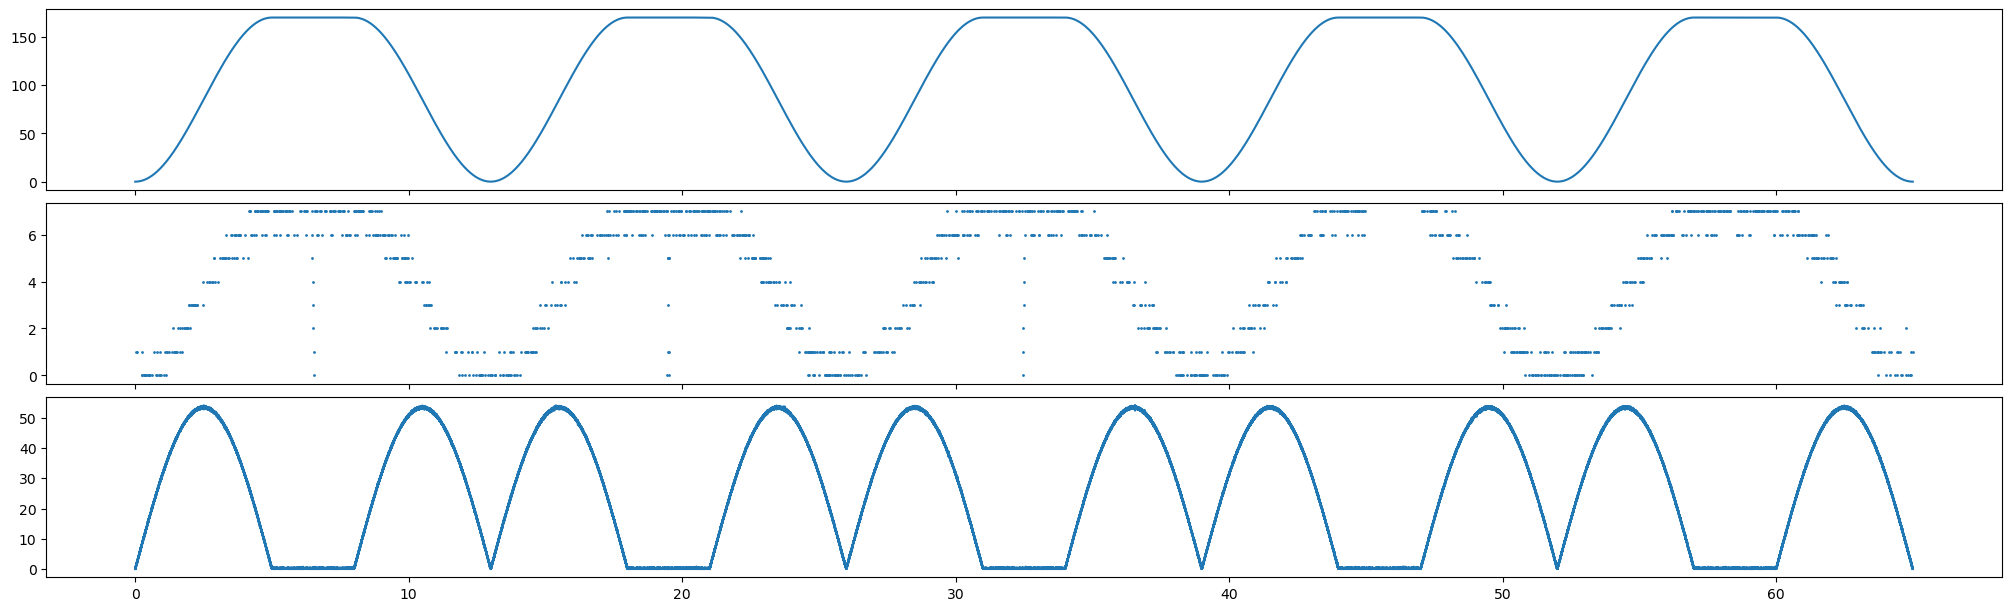

In [1]:
from non_local_detector.simulate.sorted_spikes_simulation import make_simulated_data

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

speed, position, spikes, time, ripple_times, sampling_frequency = make_simulated_data()

is_ripple = np.zeros_like(time, dtype=bool)
for ripple_time in ripple_times:
    is_ripple |= (time >= ripple_time[0]) & (time <= ripple_time[1])


fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 6))
axes[0].plot(time, position)
spike_time_ind, neuron_ind = np.nonzero(spikes)
axes[1].scatter(time[spike_time_ind], neuron_ind, s=1)
axes[2].plot(time, speed)

In [2]:
import numpy as np

from non_local_detector import NonLocalSortedSpikesDetector
from non_local_detector.environment import Environment
from non_local_detector.discrete_state_transitions import DiscreteStationaryDiagonal
from non_local_detector.continuous_state_transitions import (
    Discrete,
    Uniform,
    RandomWalk,
)

env = Environment(place_bin_size=2.0)

discrete_state_transition = DiscreteStationaryDiagonal(
    diagonal_values=np.array([0.90, 0.90, 0.90, 0.98])
)

continuous_state_transition = [
    [Discrete(), Discrete(), Uniform(), Uniform()],
    [Discrete(), Discrete(), Uniform(), Uniform()],
    [Discrete(), Discrete(), RandomWalk(movement_var=30.0), Uniform()],
    [Discrete(), Discrete(), Uniform(), Uniform()],
]

stickiness = np.array([100.0, 100_000.0, 100.0, 100.0])

sorted_spikes_algorithm_params = {
    "l2_penalty": 1e-5,
    "emission_knot_spacing": 30.0,
}

detector = NonLocalSortedSpikesDetector(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_glm_jax",
    sorted_spikes_algorithm_params=sorted_spikes_algorithm_params,
    continuous_transition_types=continuous_state_transition,
    sampling_frequency=sampling_frequency,
    discrete_transition_stickiness=stickiness,
)

is_training = ~is_ripple

detector.fit(position=position, spikes=spikes, is_training=is_training)

  0%|          | 0/8 [00:00<?, ?it/s]

NonLocalSortedSpikesDetector(continuous_initial_conditions_types=[UniformInitialConditions(),
                                                                  UniformInitialConditions(),
                                                                  UniformInitialConditions(),
                                                                  UniformInitialConditions()],
                             continuous_transition_types=[[<non_local_detector.continuous_state_transitions.Discrete object at 0x1532fa450>,
                                                           <non_local_detector.continuous_state_transitions.Discrete object at 0x...
                                                 ObservationModel(environment_name='',
                                                                  encoding_group=0,
                                                                  is_local=False,
                                                                  is_no_spike=False),
                                                 ObservationModel(environment_name='',
                                                                  encoding_group=0,
                                                                  is_local=False,
                                                                  is_no_spike=False)],
                             sampling_frequency=1500,
                             sorted_spikes_algorithm='sorted_spikes_glm_jax',
                             sorted_spikes_algorithm_params={'emission_knot_spacing': 30.0,
                                                             'l2_penalty': 1e-05},
                             state_names=['state 0', 'state 1', 'state 2',
                                          'state 3'])

In [ ]:
plt.plot(
    detector.environments[0].place_bin_centers_,
    detector.encoding_model_[("", 0)]["non_local_rates"].T * sampling_frequency,
)

In [ ]:
test_hmm = np.load("test_hmm.npz")
test_hmm.files

In [ ]:
np.allclose(
    detector.discrete_state_transitions_, test_hmm["discrete_state_transitions"]
)

In [ ]:
np.allclose(detector.initial_conditions_, test_hmm["initial_conditions"])

In [ ]:
np.allclose(
    detector.continuous_state_transitions_, test_hmm["continuous_state_transitions"]
)

In [ ]:
np.allclose(detector.state_ind_, test_hmm["state_ind"])

In [ ]:
results = detector.predict(position=position, spikes=spikes)
results

In [ ]:
np.allclose(detector.log_likelihood_, test_hmm["log_likelihood"], equal_nan=True)

In [ ]:
np.isclose(detector.log_likelihood_, test_hmm["log_likelihood"]).mean(axis=0)

In [ ]:
ind = 2
plt.plot(detector.log_likelihood_[:, ind])
plt.plot(test_hmm["log_likelihood"][:, ind], linestyle="--")
plt.xlim((0, 2000))

In [ ]:
plt.plot(np.abs(detector.log_likelihood_[:, ind] - test_hmm["log_likelihood"][:, ind]))

In [ ]:
# detector.estimate_parameters(
#     position,
#     spikes,
#     is_training=is_training,
# )

In [ ]:
np.allclose(spikes, test_hmm["spikes"])

In [ ]:
np.allclose(position, test_hmm["position"])

In [ ]:
test_hmm["coefficients"].shape

In [ ]:
np.isclose(
    detector.encoding_model_[("", 0)]["coefficients"].T, test_hmm["coefficients"]
)

In [ ]:
detector.encoding_model_[("", 0)]["coefficients"].T - test_hmm["coefficients"]

In [ ]:
test_hmm.close()

In [ ]:
from non_local_detector.visualization import plot_non_local_model

plot_non_local_model(
    results.time,
    position,
    spikes,
    speed,
    detector.encoding_model_[("", 0)]["non_local_rates"].T,
    detector.environments[0],
    detector.state_ind_,
    results.acausal_state_probabilities.values,
    results.acausal_posterior.values,
    detector.state_names,
)

In [10]:
from non_local_detector import SortedSpikesDecoder

decoder = SortedSpikesDecoder(
    environments=env,
    sorted_spikes_algorithm="sorted_spikes_glm_jax",
    sorted_spikes_algorithm_params=sorted_spikes_algorithm_params,
).fit(position, spikes, is_training=is_training)
results = decoder.predict(position, spikes)
results

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Causal
Acausal


<xarray.Dataset>
Dimensions:                      (time: 97500, state_bins: 86, states: 1,
                                  position_dims: 1)
Coordinates:
  * time                         (time) int64 0 1 2 3 ... 97497 97498 97499
  * state_bins                   (state_bins) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0
  * states                       (states) <U7 'state 0'
    environments                 (states) <U1 ''
    encoding_groups              (states) int64 0
    position                     (state_bins, position_dims) float64 0.9881 ....
Dimensions without coordinates: position_dims
Data variables:
    acausal_posterior            (time, state_bins) float32 nan nan ... nan nan
    acausal_state_probabilities  (time, states) float64 nan nan nan ... nan nan
Attributes:
    marginal_log_likelihoods:  -inf

In [11]:
results.squeeze()

<xarray.Dataset>
Dimensions:                      (time: 97500, state_bins: 86)
Coordinates:
  * time                         (time) int64 0 1 2 3 ... 97497 97498 97499
  * state_bins                   (state_bins) int64 0 0 0 0 0 0 ... 0 0 0 0 0 0
    states                       <U7 'state 0'
    environments                 <U1 ''
    encoding_groups              int64 0
    position                     (state_bins) float64 0.9881 2.965 ... 169.0
Data variables:
    acausal_posterior            (time, state_bins) float32 nan nan ... nan nan
    acausal_state_probabilities  (time) float64 nan nan nan nan ... nan nan nan
Attributes:
    marginal_log_likelihoods:  -inf

In [16]:
decoder.discrete_state_transitions_

array([[nan]])

In [22]:
diag = np.ones((1,))
n_states = len(diag)
transition_matrix = diag * np.eye(n_states)
off_diag = np.where(
    n_states - 1 == 0,
    1.0
    ((1.0 - diag) / (n_states - 1.0))[:, np.newaxis])
transition_matrix += np.ones((n_states, n_states)) * off_diag - off_diag * np.eye(
    n_states
)
transition_matrix

array([[nan]])

In [24]:
off_diag

array([[nan]])

In [25]:
(1.0 - diag)

array([0.])